In [61]:
import numpy as np
import matplotlib.pyplot as plt
import krotov
import qutip
import scipy
import os
π = np.pi
sqrt = np.sqrt
basis = qutip.basis
tensor = qutip.tensor
coherent = qutip.coherent

In [55]:
def plot_fid_convergence(ax, info_vals, T):
    ax.plot3D(range(0,len(info_vals)), [T]*len(info_vals), info_vals)

In [62]:
L = 3
def proj(ψ, ϕ=None):
    if ϕ is None:
        return ψ * ψ.dag()
    else:
        return ψ * ϕ.dag()
Si = qutip.operators.identity(L)
ZERO = qutip.operators.qzero(L)

σ_z = proj(qutip.basis(L, 0)) - proj(qutip.basis(L, 1))
σ_y = 1j*(proj(qutip.basis(L, 1),qutip.basis(L, 0)) - proj(qutip.basis(L, 0), qutip.basis(L, 1)))
σ_x = proj(qutip.basis(L, 0),qutip.basis(L, 1)) - proj(qutip.basis(L, 1), qutip.basis(L, 0))
b = qutip.operators.destroy(L)
I = Si

ω_r = 8.3056 * 2 * π      # resonator frequency
ω_q = 6.2815 * 2 * π      # qubit frequency
K_q   = -2*π*297e-3    # Kerr qubit 200-300 MHz
use_rotating = True
def hamiltonian(ω=1.0, ampl0=1, use_rotating=True, pulses=None, tlist=None):
    """Two-level-system Hamiltonian
    
    Args:
        ω (float): energy separation of the qubit levels
        ampl0 (float): constant amplitude of the driving field
    """
    
    K_r   = 2*π*0.45e-3   # Kerr res
    K_q   = -2*π*297e-3    # Kerr qubit 200-300 MHz
    ω_r = 8.3056 * 2 * π      # resonator frequency
    ω_q = 6.2815 * 2 * π      # qubit frequency
    χ = 0.025 * 2 * π   # parameter in the dispersive hamiltonian

    Δ = abs(ω_r - ω_q)    # detuning
    g = sqrt(Δ * χ)  # coupling strength that is consistent with chi
    γ = 1e1
    
    #H_occ = w_r*a.dag()*a + w_q*b.dag()*b
    if L==3:
        H_occ_q = qutip.Qobj(np.diag([0, ω_q, 2*ω_q]))
    else:
        H_occ_q = qutip.Qobj(np.diag([0, ω_q]))
    #H_occ_r = ω_r * a.dag()*a
    H_occ =  H_occ_q#  + H_occ_r
    
    
    use_dispersive = True
    use_kerr = False
    #if use_dispersive:
    #    #H_coup = - chi_qr * a.dag()*a * b.dag()*b
    #    H_coup =  χ * (a.dag()*a + I/2) * σ_z
    #else:
        #H_coup = g * (a.dag() * b + a * b.dag())
    #    H_coup = g * σ_x *a.dag() + a
    if use_kerr:
        H_kerr = - K_q/2 * b.dag()**2 * b**2
    else:
        H_kerr = ZERO
    
    H_d = ZERO
    
    if use_rotating:
        H_d += H_kerr
        
        H_qr = (b.dag() + b)
        H_qi = 1j*(b.dag() - b)
        #H_rr = (a + a.dag())
        #H_ri = 1j*(a.dag() - a)
        
        
        ϵ_qr = lambda t, args: ampl0
        ϵ_qi = lambda t, args: ampl0
        #ϵ_rr = lambda t, args: ampl0
        #ϵ_ri = lambda t, args: ampl0
        
        # Random pulses (doesn't really work)
        #ϵ = lambda t, tlist, R: R[np.where(tlist<=t)[0][-1]]
        #O = np.random.rand(len(tlist))
        #ϵ_qr = lambda t, args: ϵ(t, tlist, O)
        #O = np.random.rand(len(tlist))
        #ϵ_qi = lambda t, args: ϵ(t, tlist, O)
        
        
        if pulses:
            ϵ_qr = pulses[0]
            ϵ_qi = pulses[1]
        #    ϵ_rr = np.zeros(len(pulses[0]))
        #    ϵ_ri = np.zeros(len(pulses[0]))

        return [H_d, [H_qr, ϵ_qr], [H_qi, ϵ_qi]]#, [H_rr, ϵ_rr], [H_ri, ϵ_ri]]
    else:
        H_d += H_occ + H_kerr#+ H_coup
        
        H_q = b
        H_qc = b.dag()
        #H_rr = ZERO
        #H_ri = ZERO
        

        ϵ_q = lambda t, args: 1j*ampl0*np.exp(1j*ω_q*t)
        ϵ_qc = lambda t, args: -1j*ampl0*np.exp(-1j*ω_q*t)
        #ϵ_rr = lambda t, args: ampl0
        #ϵ_ri = lambda t, args: ampl0
        
        if pulses:
            ϵ_q = pulses[0]
            ϵ_qc = pulses[1]
            #ϵ_rr = np.zeros(len(pulses[0]))
            #ϵ_ri = np.zeros(len(pulses[0]))
        
        return [H_d, [H_q, ϵ_q], [H_qc, ϵ_qc]]#, [H_rr, ϵ_rr], [H_ri, ϵ_ri]]


In [63]:
def state_rot(ϕ, T):
    if L == 3:
        rot_evo = qutip.Qobj([[1, 0, 0],[0, np.exp(-1j * ω_q * T), 0],[0, 0, 0]])
    else:
        rot_evo = qutip.Qobj([[1, 0],[0, np.exp(-1j * ω_q * T)]])
    ϕ[0][1] = rot_evo * ϕ[0][1]
    return ϕ

H = hamiltonian(ampl0=1, use_rotating=True)
ϕ = [[ basis(L,0), (basis(L,0)-basis(L,1)).unit() ]]

if use_rotating:
    objectives = [krotov.Objective(initial_state=ψ[0], target=ψ[1], H=H) for ψ in state_rot(ϕ, T)]
else:
    objectives = [krotov.Objective(initial_state=ψ[0], target=ψ[1], H=H) for ψ in ϕ]

In [83]:
def plot_population(n, tlist):
    fig, ax = plt.subplots()
    leg = []
    for i in range(len(n)):
        ax.plot(tlist, n[i], label=str(i))
        leg.append(str(i))
    ax.legend()
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Occupation')
    ax.legend(leg)
    plt.show(fig)
def qubit_occupation(dyn):
    occ = [basis(L,i)*basis(L,i).dag() for i in range(0,L)]
    n = qutip.expect(occ, dyn.states)
    plot_population(n, dyn.times)
def plot_pulse(pulse, tlist):
    fig, ax = plt.subplots(figsize=(15,4))
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    if np.any(np.iscomplex(pulse)):
        ax.plot(tlist, np.real(pulse))
        ax.plot(tlist, np.imag(pulse))
        ax.legend(['Re', 'Im'])
    else:
        ax.plot(tlist, pulse)
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('Pulse amplitude')
    plt.show(fig)
def plot_spectrum(pulse, tlist, mark_freq=None, pos=1):
    samples = len(tlist)
    sample_interval = tlist[-1]/samples
    time = np.linspace(0, samples*sample_interval, samples)

    signal_qubit = pulse
    signal_spectrum = np.fft.fftshift(np.fft.fft(signal_qubit))
    freqs = np.fft.fftshift(np.fft.fftfreq(samples, d=sample_interval))

    plt.figure(figsize=(10,5))
    plt.plot(freqs, np.abs(signal_spectrum))  # in GHz
    if mark_freq is not None:
        if not isinstance(mark_freq, list):
            mark_freq = [mark_freq]
        mf = np.array(mark_freq)/(2*π)
        if pos==1:
            plt.xlim(0, 2*mf[0])
        elif pos==-1:
            plt.xlim(-2*mf[0], 0)
        [plt.axvline(x=pos*m_f, ymin=0, ymax=1, color='k', linestyle='--', linewidth=1) for m_f in mf]
    plt.title('Qubit pulse spectrum')
    plt.xlabel('f (GHz)');

F = 0.9999856419210207


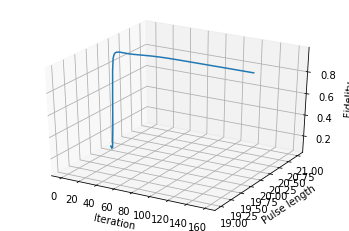

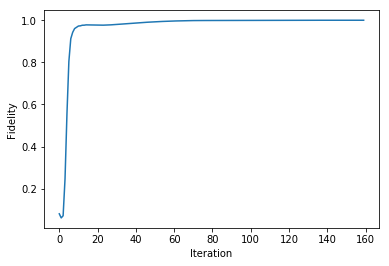

In [174]:
results = [(krotov.result.Result.load(os.path.join(os.getcwd(),'results',file), objectives=objectives), float(file.split('_')[-1][:-4])) for file in os.listdir('results') if file[-4:]=='.dat' and file.find('_20.')>0]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlabel('Iteration')
ax.set_zlabel('Fidelity')
ax.set_ylabel('Pulse length')
for (r, T) in results:
    plot_fid_convergence(ax, r.info_vals, T)

fig = plt.figure()
ax = plt.axes()
ax.set_xlabel('Iteration')
ax.set_ylabel('Fidelity')
for (r, T) in results:
    ax.plot(range(0,len(r.info_vals)), r.info_vals)
    print('F = {}'.format(r.info_vals[-1]))

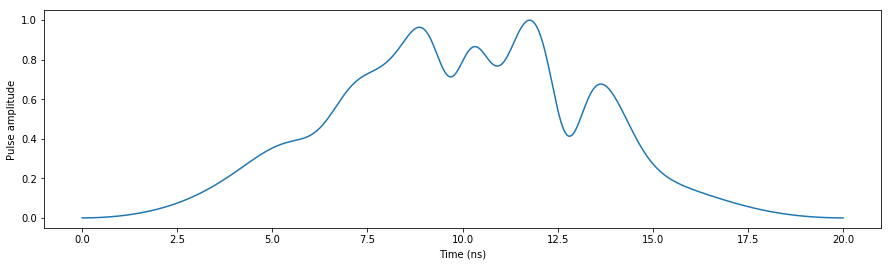

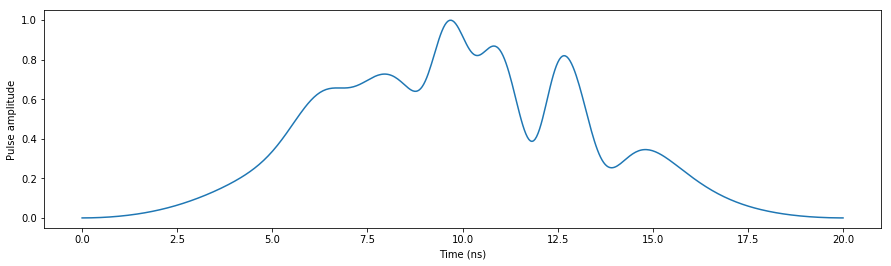

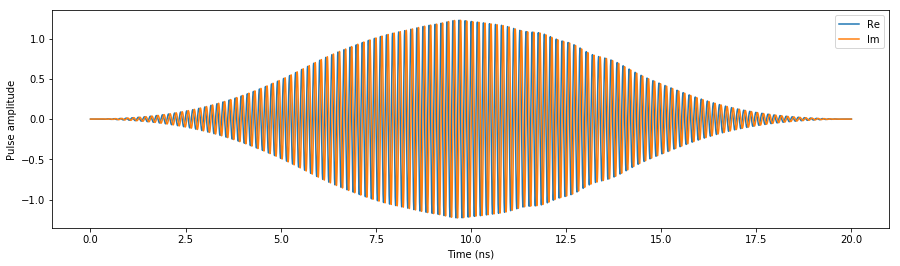

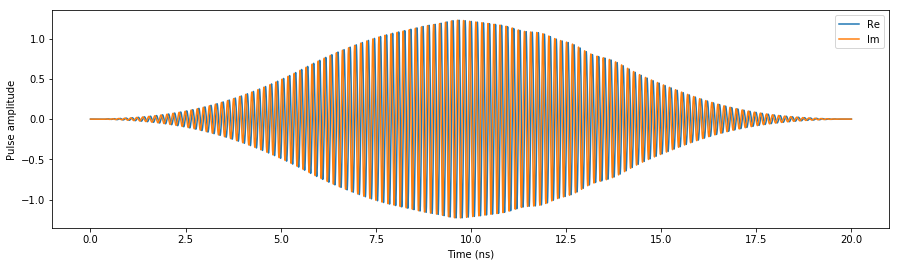

/home/wello/miniconda3/envs/qutip-env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /mnt/c/Users/johan/Development/cat-state-encoding/Krotov/rhs184737.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


10.0%. Run time:   0.04s. Est. time left: 00:00:00:00
20.0%. Run time:   0.08s. Est. time left: 00:00:00:00
30.0%. Run time:   0.12s. Est. time left: 00:00:00:00
40.0%. Run time:   0.16s. Est. time left: 00:00:00:00
50.0%. Run time:   0.21s. Est. time left: 00:00:00:00
60.0%. Run time:   0.25s. Est. time left: 00:00:00:00
70.0%. Run time:   0.30s. Est. time left: 00:00:00:00
80.0%. Run time:   0.34s. Est. time left: 00:00:00:00
90.0%. Run time:   0.38s. Est. time left: 00:00:00:00
Total run time:   0.42s


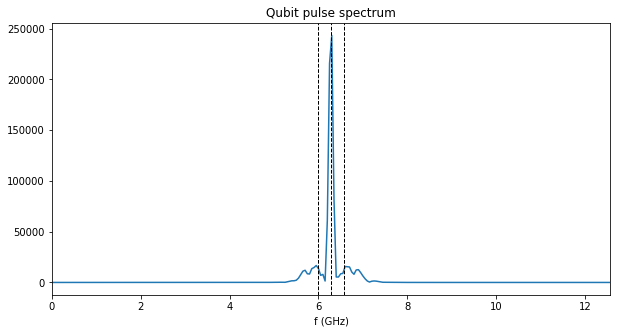

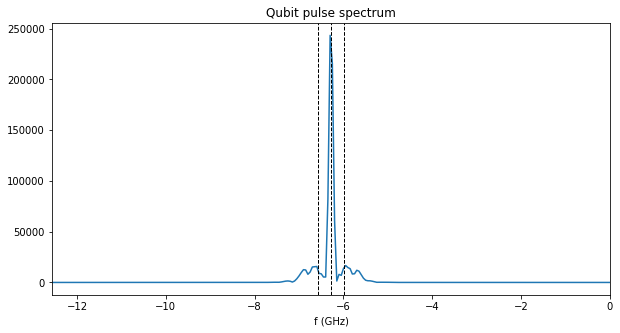

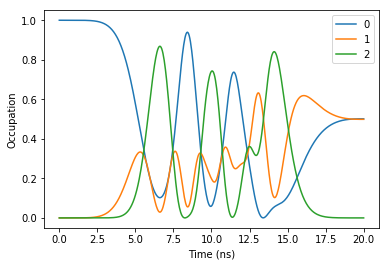

In [175]:
T_q = (2*π)/ω_q
steps2 = len(results[0][0].tlist)*1000
for (r,_) in results:
    tlist = r.tlist
    for c in [r.optimized_controls]:
        plot_pulse(c[0], tlist)
        plot_pulse(c[1], tlist)
        tlist2 = np.linspace(0, tlist[-1], steps2)
        Ω = c[0]+1j*c[1]
        Ω = np.interp(tlist2, tlist, Ω)
        pulses_lab = [Ω*np.exp(1j*ω_q*tlist2), np.conj(Ω)*np.exp(-1j*ω_q*tlist2)]
        plot_pulse(pulses_lab[0], tlist2)
        plot_pulse(pulses_lab[1], tlist2)
        plot_spectrum(pulses_lab[0], tlist2, mark_freq=[ω_q, ω_q + K_q, ω_q - K_q], pos=1)
        plot_spectrum(pulses_lab[1], tlist2, mark_freq=[ω_q, ω_q + K_q, ω_q - K_q], pos=-1)
    opt_dynamics = [ob.mesolve(tlist, progress_bar=True) for ob in r.optimized_objectives]
    qubit_occupation(opt_dynamics[0])